In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
DATA_DIR = '../data/'
df = pd.read_csv(DATA_DIR+'Most-Recent-Cohorts-Institution.csv', low_memory=False)

In [52]:
df = df.replace('PrivacySuppressed', np.nan)

In [53]:
df.shape

(6543, 3232)

In [54]:
nan_percentage = df.isna().mean()

# Filter out columns with more than 30% NaN values
df_cleaned = df.loc[:, nan_percentage <= 0.3].copy()


In [55]:
df_cleaned.shape

(6543, 689)

In [56]:
print(len(df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('float64')]))
print(len(df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('int64')]))
print(len(df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('object')]))

363
15
311


In [57]:
# Find columns which cannot be coerced to object dtype. 
# These are actual categorical columns of potential interest.
err_cols = set()
for col in df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('object')]:
    try:
        pd.to_numeric(df_cleaned[col], errors='raise')
    except:
        err_cols.add(col)


In [58]:
# Coerce whatever columns which can be coerced. These are numeric columns.
for column in df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('object')]:
    if column not in err_cols:
        df_cleaned.loc[:, column] = pd.to_numeric(df_cleaned[column], errors='coerce')


In [59]:
print(len(df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('float64')]))
print(len(df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('int64')]))
print(len(df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('object')]))

615
15
59


In [60]:
# Borrower-Based Repayment Rate on Federal Loans: 
# BBRR[YR]_[LOAN]_[GROUP]_[STATUS]
# [YR]=1, 2, 3, or 4
# [STATUS]:
# DFTL - Default - Not paid for 360+ days
# DLNQ - Delinquent - Not paying for 31 to 360 days
# FBR - Forbearance - Temporary stop
# DFR - Deferment 
# NOPROG - Not making progress
# MAKEPROG - Making progress
# PAIDINFULL - Paid in full
# Discharged - Discharged - obligation to pay removed
# GROUP - UG, GR, UGCOMP. UGNOCOMP, GRCOMP, GRNOCOMP
# comp means completion 
# more info @ page 33-34

# questionable_cols = ['FEDSCHCD']
# ACCREDAGENCY <-- str to cat

# val_cat_cols = ['ACCREDAGENCY', 'ACCREDCODE']
# dates = ['SEPAR_DT_MDN', 'T4APPROVALDATE']
# ACCREDCODE is the code for ACCREDAGENCY, so one can be safely dropped
# IDS = ['UNITID']
# drop col = ['MDCOST_ALL', 'MDEARN_ALL'] # <== value is 16007 and 38461 respectively for all rows!


In [61]:
num_cols = set(df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('float64')])
cat_cols = set(df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('object')]) | set(df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('int64')])

cat_cols_to_drop = set([
    'FEDSCHCD', 'MDCO1ST_ALL', 'MDEARN_ALL',# no idea what these are
    'ACCREDAGENCY',                         # duplicate of ACCREDCODE
    'SEPAR_DT_MDN', 'T4APPROVALDATE',       # dates
    'INSTURL', 'NPCURL',                    # urls
    'UNITID',                               # ID column
    'ADDR', 'ZIP',                          # institute address
    'INSTNM'                                # institute name
])
cat_cols -= cat_cols_to_drop
cat_cols = [c for c in cat_cols if not c.startswith('BBRR')] # dropping BBRR for now
num_cols = [c for c in num_cols if not c.startswith('BBRR')]

In [62]:
# fill all num cols by median values
for column in df_cleaned[num_cols].columns:
    median_value = df_cleaned[column].median()
    df_cleaned[column].fillna(median_value, inplace=True)

# fill all cat cols by most frequent values
for column in df_cleaned[cat_cols].columns:
    mode_value = df_cleaned[column].mode()[0]
    df_cleaned[column].fillna(mode_value, inplace=True)

In [63]:
df_cleaned = df_cleaned[num_cols + cat_cols]

In [65]:
df_cleaned.isna().sum().sum()

0

In [16]:
# target column = 'DEBT_MDN'

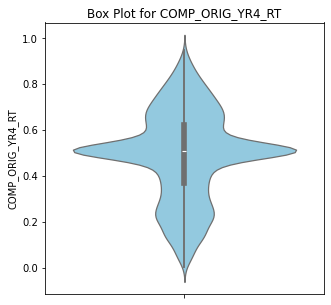

In [17]:
# df_cleaned['COMP_ORIG_YR4_RT'].plot.hist()
plt.figure(figsize=(5, 5))  # Set the figure size
sns.violinplot(data=df_cleaned, y='COMP_ORIG_YR4_RT', color='skyblue')
plt.title(f'Box Plot for COMP_ORIG_YR4_RT')
plt.show()

<AxesSubplot:ylabel='Frequency'>

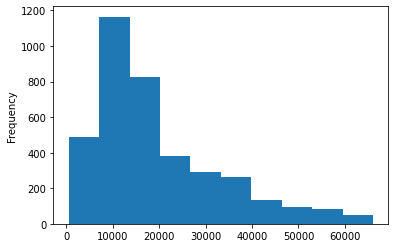

In [18]:
df['TUITIONFEE_OUT'].plot.hist()

In [19]:
df['TUITIONFEE_OUT'].isna().sum()

2756

In [20]:
df['ROOMBOARD_OFF'].isna().sum()

3168

In [21]:
df_cleaned['DEBT_MDN']

0       16600.0
1       15832.0
2       13385.0
3       13905.0
4       17500.0
         ...   
6538    19500.0
6539    19500.0
6540    19500.0
6541    19500.0
6542     9500.0
Name: DEBT_MDN, Length: 6543, dtype: float64

In [22]:
df_cleaned.to_csv(DATA_DIR+'cleaned.csv', index=False)
